## Filtering with SWE --- "immersed bump" example
*Connor Duffin*

In this notebok we are looking at DA for the shallow water equations using a linearised approximation to the SWE and using an extended Kalman filter (ExKF). In both cases, data is generated using the fully nonlinear SWE, with a variable topography. In this case there is no misspecification (aside from the use of the linearised equations underlying the filter).

In these scenarios we have a bump immersed in the terrain. We study the assimilation regime where approx $63$ points are observed at the observed timepoints. We observed every $4$ timesteps, giving a time between observations as $4 \Delta_t = 0.04$s.

First, we load in the appropriate libraries and get the sim set up:

In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
sys.path.insert(0, "../scripts")

from pyDOE import lhs
from scipy.linalg import cho_factor, cho_solve
from statfenics.utils import build_observation_operator
from swe import ShallowOne, ShallowOneLinear
from swe_filter import ShallowOneKalman, ShallowOneEx
from tqdm import tqdm

np.random.seed(28)

To sanity check the sim we plot the leading eigenvalues for each of the filters: these should be the same for each of the filters. notice that there is lots of "headroom" for the filters in that the approximation is very accurate.

In [2]:
norm = np.linalg.norm

NX = 500
DT = 0.01
THETA = 0.6
NU = 1e-6

# set the observation system
t_final = 120.
nt = np.int64(t_final / DT)
t_grid = np.arange(0., t_final, DT)
print(t_grid.shape)

k = 16
nt_skip = 20
sigma_y = 5e-4

swe_dgp = ShallowOne(
    control=dict(nx=NX, dt=DT, theta=THETA, simulation="immersed_bump"),
    params=dict(nu=NU))

stat_params = dict(rho_u=1e-4, ell_u=5.,
                   rho_h=1., ell_h=5,
                   k=k, k_init_u=k, k_init_h=k,
                   hilbert_gp=True)

swe_post = ShallowOneKalman(
    control=dict(nx=NX, dt=DT, theta=THETA),
    params=dict(nu=0.),
    stat_params=stat_params,
    lr=True)

nu_alt = 0.1
swe_prior = ShallowOneEx(
    control=dict(nx=NX, dt=DT, theta=THETA, simulation="immersed_bump"),
    params=dict(nu=0.1),
    stat_params=stat_params,
    lr=True)

swe_post_ex = ShallowOneEx(
    control=dict(nx=NX, dt=DT, theta=THETA, simulation="immersed_bump"),
    params=dict(nu=0.1),
    stat_params=stat_params,
    lr=True)

# build obs. operator
x_obs = swe_dgp.L * lhs(1, 5)
nx_obs = len(x_obs)
nt_obs = len([i for i in range(nt) if i % nt_skip == 0])
H_obs = build_observation_operator(x_obs, swe_post.W, sub=1, out="scipy")

H_u_verts = build_observation_operator(swe_dgp.x_coords, swe_dgp.W, sub=0)
H_h_verts = build_observation_operator(swe_dgp.x_coords, swe_dgp.W, sub=1)

print(f"Assimilating every {nt_skip} timesteps ({nt_skip * swe_dgp.dt:.3f} s)")
print(f"Observational noise has std. dev. {sigma_y:.4e}")
print(f"Assimilating {H_obs.shape[0]} data points per time")

(12000,)
Assimilating every 20 timesteps (0.200 s)
Observational noise has std. dev. 5.0000e-04
Assimilating 5 data points per time


In [3]:
def compute_mahalanobis(post, true, H_verts):
    """ Compute diagonally-approximated Mahalanobis dist.
    
    Computed on a regular grid.
    """
    v_post = H_verts @ post.mean
    v_true = H_verts @ true.du.vector().get_local()

    HL = H_verts @ post.cov_sqrt    
    var_verts = np.sum(HL**2, axis=1)
    
    scaled_diff = (v_post - v_true) / np.sqrt(var_verts)
    return norm(scaled_diff)


def compute_rmse(post, y_obs, H_obs, relative=True):
    """ Compute the error norm. Computed on a regular grid. """
    y_post = H_obs @ post.mean
    return norm(y_post - y_obs) / norm(y_obs)


def compute_errors(post, true, H_verts, relative=True):
    """ Compute the error norm. Computed on a regular grid. """
    v_post = H_verts @ post.mean
    v_true = H_verts @ true.du.vector().get_local()
    v_norm_diff = norm(v_post - v_true)
    
    if relative:
        return v_norm_diff / norm(v_true)
    else:
        return v_norm_diff

    
def compute_pp(H, swe_post): 
    mean_obs = H @ swe_post.mean 
    HL = H @ swe_post.cov_sqrt
    cov_obs = HL @ HL.T
    cov_obs[np.diag_indices_from(cov_obs)] += sigma_y**2 + 1e-10
    return mean_obs, cov_obs


mahalanobis_u_ex = np.zeros((nt, ))
mahalanobis_h_ex = np.zeros((nt, ))

mahalanobis_u = np.zeros((nt, ))
mahalanobis_h = np.zeros((nt, ))

errors_u = np.zeros((nt, ))
errors_h = np.zeros((nt, ))

errors_u_ex = np.zeros((nt, ))
errors_h_ex = np.zeros((nt, ))

y_obs = np.zeros((nt_obs, nx_obs))
means_obs = np.zeros((nt_obs, nx_obs))
covs_obs = np.zeros((nt_obs, nx_obs, nx_obs))

rmse = np.zeros((nt_obs, ))
rmse_ex = np.zeros((nt_obs, ))
rmse_prior_ex = np.zeros((nt_obs, ))

lml = np.zeros((nt_obs, ))
lml_ex = np.zeros((nt_obs, ))

t = 0.
i_save = 0
for i in tqdm(range(nt)):
    t += swe_post.dt

    swe_dgp.solve(t)
    swe_prior.prediction_step(t)
    swe_post.prediction_step(t)
    swe_post_ex.prediction_step(t)
    
    if i % nt_skip == 0:
        y_obs[i_save, :] = H_obs @ swe_dgp.du.vector().get_local()
        y_obs[i_save, :] += sigma_y * np.random.normal(size=(nx_obs, ))
        
        lml[i_save] = swe_post.compute_lml(y_obs[i_save, :], H_obs, sigma_y)
        lml_ex[i_save] = swe_post_ex.compute_lml(y_obs[i_save, :], H_obs, sigma_y)
        
        swe_post.update_step(y_obs[i_save, :], H_obs, sigma_y)
        swe_post_ex.update_step(y_obs[i_save, :], H_obs, sigma_y)
        
        rmse[i_save] = compute_rmse(swe_post, y_obs[i_save, :], H_obs)
        rmse_ex[i_save] = compute_rmse(swe_post_ex, y_obs[i_save, :], H_obs)
        rmse_prior_ex[i_save] = compute_rmse(swe_prior, y_obs[i_save, :], H_obs)
        
        means_obs[i_save, :], covs_obs[i_save, :, :] = compute_pp(H_obs, swe_post)
        i_save += 1
        
    mahalanobis_u_ex[i], mahalanobis_h_ex[i] = (compute_mahalanobis(swe_post_ex, swe_dgp, H_u_verts),
                                                compute_mahalanobis(swe_post_ex, swe_dgp, H_h_verts))
    mahalanobis_u[i], mahalanobis_h[i] = (compute_mahalanobis(swe_post, swe_dgp, H_u_verts),
                                          compute_mahalanobis(swe_post, swe_dgp, H_h_verts))
    errors_u[i], errors_h[i] = (compute_errors(swe_post, swe_dgp, H_u_verts, relative=True),
                                compute_errors(swe_post, swe_dgp, H_h_verts, relative=True))
    errors_u_ex[i], errors_h_ex[i] = (compute_errors(swe_post_ex, swe_dgp, H_u_verts, relative=True),
                                      compute_errors(swe_post_ex, swe_dgp, H_h_verts, relative=True))
    
    swe_prior.set_prev()
    swe_post.set_prev()
    swe_post_ex.set_prev()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [04:06<00:00, 48.77it/s]


In [4]:
print(f'{np.sum(lml):.4e}', f'{np.sum(lml_ex):.4e}')

-3.3779e+09 -2.1335e+10


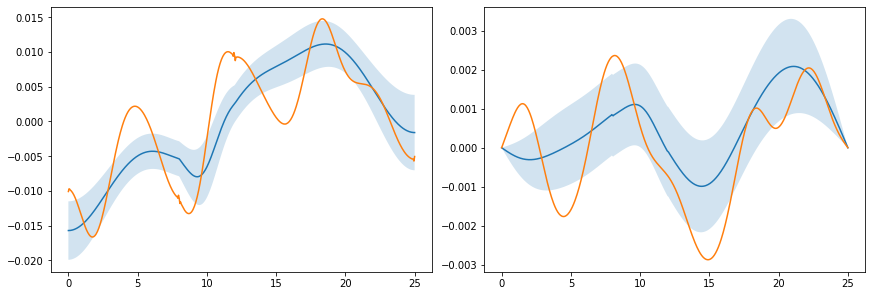

In [5]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

u_true, h_true = swe_dgp.get_vertex_values()
u_mean, h_mean = swe_post.get_vertex_values()
h_mean_alt = H_h_verts @ swe_post.mean

var_u = np.diagonal(H_u_verts @ swe_post.cov_sqrt @ (H_u_verts @ swe_post.cov_sqrt).T)
var_h = np.diagonal(H_h_verts @ swe_post.cov_sqrt @ (H_h_verts @ swe_post.cov_sqrt).T)

u_mean_ex, h_mean_ex = swe_post_ex.get_vertex_values()
u_mean_ex_alt = H_u_verts @ swe_post_ex.mean

var_u_ex = np.sum((H_u_verts @ swe_post_ex.cov_sqrt)**2, axis=1)
var_h_ex = np.sum((H_h_verts @ swe_post_ex.cov_sqrt)**2, axis=1)

axs[0].plot(swe_dgp.x_coords, u_mean_ex)
axs[0].fill_between(swe_dgp.x_coords[:, 0], 
                    u_mean_ex - 1.96 * np.sqrt(var_u_ex), u_mean_ex + 1.96 * np.sqrt(var_u_ex),
                    alpha=0.2)
axs[0].plot(swe_dgp.x_coords, u_true)

axs[1].plot(swe_dgp.x_coords, h_mean_ex)
axs[1].fill_between(swe_dgp.x_coords[:, 0], 
                    h_mean_ex - 1.96 * np.sqrt(var_h_ex), h_mean_ex + 1.96 * np.sqrt(var_h_ex),
                    alpha=0.2)
axs[1].plot(swe_dgp.x_coords, h_true)
# axs[1].plot(x_obs,  y_obs[-1, :], ".")
plt.show()

In [6]:
print(norm(h_mean_ex - h_true) / norm(h_true))
print(norm(h_mean - h_true) / norm(h_true))

print(errors_h_ex[-1])
print(errors_h[-1])

0.7224709536166123
0.20148858715773973
0.7224709536166123
0.20148858715773973


Now we check, in the meantime, to make sure that a quicker variance calculation works out OK:

In [7]:
var_u_alt = np.sum((H_u_verts @ swe_post_ex.cov_sqrt)**2, axis=1)
var_h_alt = np.sum((H_h_verts @ swe_post_ex.cov_sqrt)**2, axis=1)

np.testing.assert_allclose(var_u_alt, var_u_ex)
np.testing.assert_allclose(var_h_alt, var_h_ex)

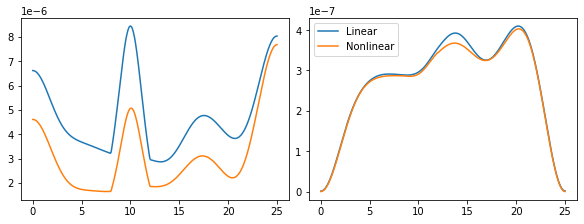

In [8]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 3))
axs[0].plot(swe_post.x_coords, var_u)
axs[0].plot(swe_post.x_coords, var_u_ex)
axs[1].plot(swe_post.x_coords, var_h, label="Linear")
axs[1].plot(swe_post.x_coords, var_h_ex, label="Nonlinear")
axs[1].legend()
plt.show()

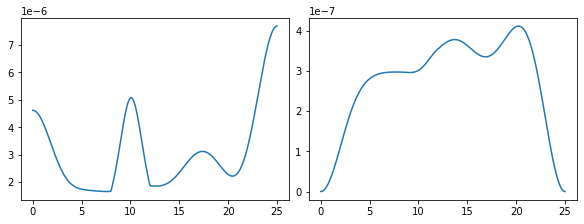

In [9]:
t += swe_post_ex.dt
swe_post_ex.prediction_step(t)
var_u_alt = np.sum((H_u_verts @ swe_post_ex.cov_sqrt)**2, axis=1)
var_h_alt = np.sum((H_h_verts @ swe_post_ex.cov_sqrt)**2, axis=1)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 3))
axs[0].plot(swe_post.x_coords, var_u_alt)
axs[1].plot(swe_post.x_coords, var_h_alt)
plt.show()

Next we plot the relative errors and we see that they look OK:

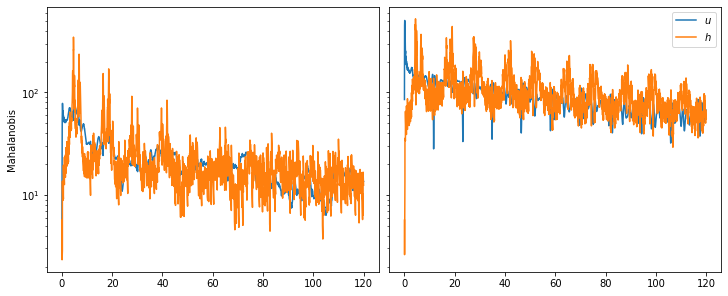

In [10]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4), sharey=True)
axs[0].semilogy(t_grid, mahalanobis_u)
axs[0].semilogy(t_grid, mahalanobis_h)
axs[0].set_ylabel("Mahalanobis")
axs[1].semilogy(t_grid, mahalanobis_u_ex, label=r"$u$")
axs[1].semilogy(t_grid, mahalanobis_h_ex, label=r"$h$")
axs[1].legend()
plt.show()

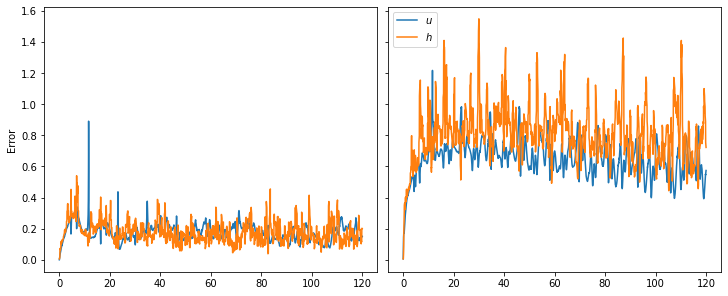

In [11]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4), sharey=True)
axs[0].plot(t_grid, errors_u)
axs[0].plot(t_grid, errors_h)
axs[0].set_ylabel("Error")
axs[1].plot(t_grid, errors_u_ex, label=r"$u$")
axs[1].plot(t_grid, errors_h_ex, label=r"$h$")
axs[1].legend()
plt.show()

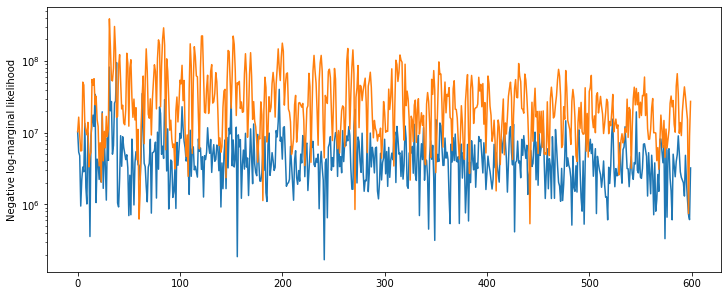

In [12]:
fig, ax = plt.subplots(1, 1,  constrained_layout=True, figsize=(10, 4))
ax.semilogy(-lml)
ax.semilogy(-lml_ex)
ax.set_ylabel("Negative log-marginal likelihood")
plt.show()

In [13]:
n_start = nt // 2

print(np.sum(mahalanobis_u[n_start:]))
print(np.sum(mahalanobis_h[n_start:]))
print(np.sum(mahalanobis_u_ex[n_start:]))
print(np.sum(mahalanobis_h_ex[n_start:]))

print(np.sum(errors_u[n_start:]))
print(np.sum(errors_h[n_start:]))
print(np.sum(errors_u_ex[n_start:]))
print(np.sum(errors_h_ex[n_start:]))

87930.34015570284
92686.96167596606
416289.10076902295
493169.87843021844
996.3392934768366
1008.5544539737698
3771.662637941534
4785.278266411648


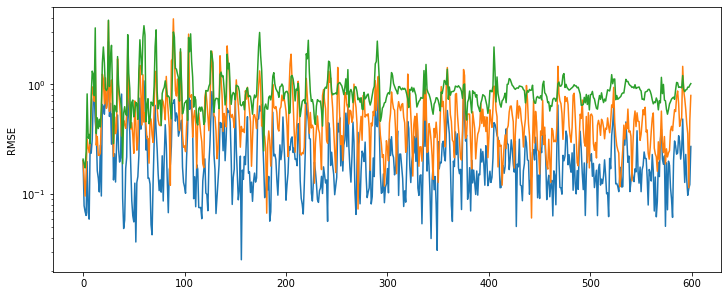

In [14]:
fig, ax = plt.subplots(1, 1,  constrained_layout=True, figsize=(10, 4))
ax.semilogy(rmse)
ax.semilogy(rmse_ex)
ax.semilogy(rmse_prior_ex)
ax.set_ylabel("RMSE")
plt.show()

In [15]:
print(np.sum(rmse) / len(rmse), 
      np.sum(rmse_ex) / len(rmse_ex), 
      np.sum(rmse_prior_ex) / len(rmse_prior_ex))

0.24277831378271875 0.5407851096184184 0.9053378245381177


Next, we look at the prediction means and variances

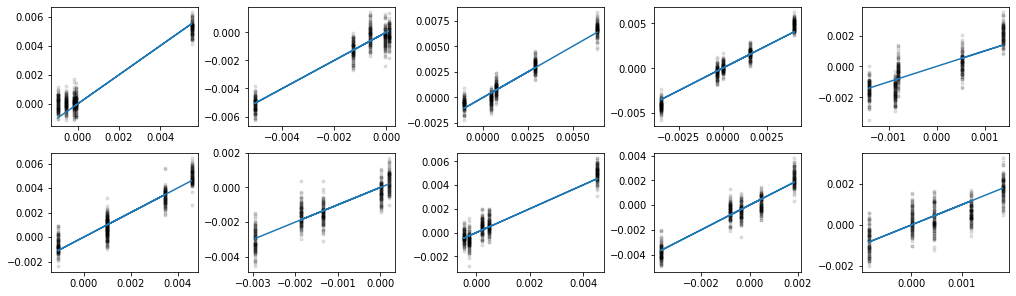

In [16]:
time_indices = np.int64(np.linspace(0, nt_obs - 1, 10))
fig, axs = plt.subplots(2, 5, constrained_layout=True, figsize=(14, 4))
axs = axs.flatten()
for i, idx in enumerate(time_indices):
    mean = means_obs[idx, :]
    cov = covs_obs[idx, :]
    y = y_obs[idx, :]
    samples = np.random.multivariate_normal(mean=mean, cov=cov, size=100)
    
    axs[i].plot(y, samples.T, ".", alpha=0.1, color="black")
    axs[i].plot(y, y)
    

In [17]:
coverage = np.zeros((nt_obs, ))
for i in range(nt_obs):
    mean = means_obs[i, :]
    cov = covs_obs[i, :]
    y = y_obs[i, :]
    lower = mean - 1.96 * np.sqrt(cov.diagonal())
    upper = mean + 1.96 * np.sqrt(cov.diagonal())
    coverage[i] = ((y > lower) & (y < upper)).sum() / nx_obs


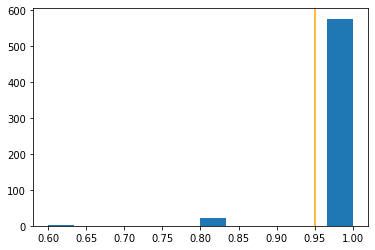

In [18]:
plt.hist(coverage, bins=12)
plt.axvline(x=0.95, color="orange")
plt.show()

In [19]:
for i in tqdm(range(int(5. / DT))):  # forecast forward 5s
    t += swe_post.dt
    swe_dgp.solve(t)
    
    swe_post_ex.prediction_step(t)
    swe_post_ex.set_prev()
    
    swe_post.prediction_step(t)
    swe_post.set_prev()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 76.20it/s]


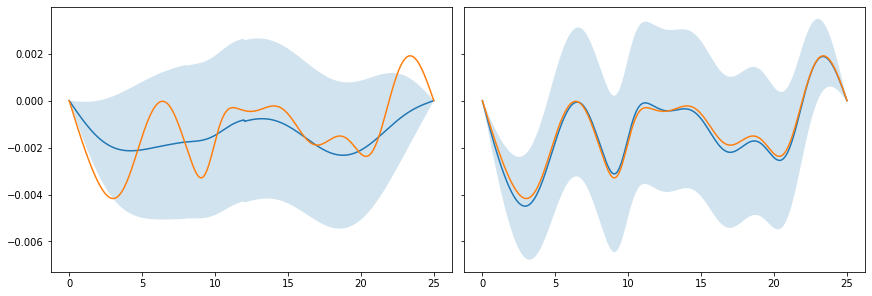

In [20]:
H_u_verts = build_observation_operator(swe_dgp.x_coords, swe_dgp.W, sub=0)
H_h_verts = build_observation_operator(swe_dgp.x_coords, swe_dgp.W, sub=1)

u_true, h_true = swe_dgp.get_vertex_values()
u_mean, h_mean = swe_post.get_vertex_values()
u_mean_ex, h_mean_ex = swe_post_ex.get_vertex_values()

var_u = np.diagonal(H_u_verts @ swe_post.cov_sqrt 
                    @ (H_u_verts @ swe_post.cov_sqrt).T)
var_h = np.diagonal(H_h_verts @ swe_post.cov_sqrt 
                    @ (H_h_verts @ swe_post.cov_sqrt).T)

var_u_ex = np.diagonal(H_u_verts @ swe_post_ex.cov_sqrt 
                       @ (H_u_verts @ swe_post_ex.cov_sqrt).T)
var_h_ex = np.diagonal(H_h_verts @ swe_post_ex.cov_sqrt 
                       @ (H_h_verts @ swe_post_ex.cov_sqrt).T)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4), sharey=True)
axs[0].plot(swe_dgp.x_coords, h_mean_ex)
axs[0].fill_between(swe_dgp.x_coords[:, 0], 
                    h_mean_ex - 1.96 * np.sqrt(var_h_ex), 
                    h_mean_ex + 1.96 * np.sqrt(var_h_ex),
                    alpha=0.2)
axs[0].plot(swe_dgp.x_coords, h_true)

axs[1].plot(swe_dgp.x_coords, h_mean)
axs[1].fill_between(swe_dgp.x_coords[:, 0], 
                    h_mean - 1.96 * np.sqrt(var_h), h_mean + 1.96 * np.sqrt(var_h),
                    alpha=0.2)
axs[1].plot(swe_dgp.x_coords, h_true)
plt.show()

In [21]:
print(norm(h_true - h_mean) / norm(h_true))
print(norm(h_true - h_mean_ex) / norm(h_true))


0.10671985249772477
0.598918541832491


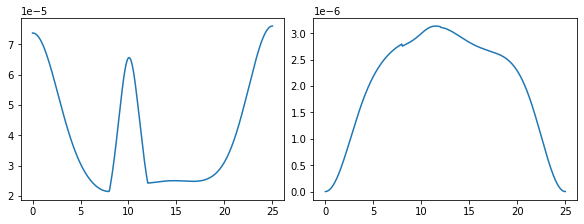

In [22]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 3))
axs[0].plot(swe_post.x_coords, var_u_ex)
axs[1].plot(swe_post.x_coords, var_h_ex)
plt.show()